### ConjugateGradients.jl  from SeisReconstruction

#### https://github.com/SeismicJulia/SeisReconstruction.jl


The Conjugate Gradient Least-squares (CGLS) algorithm used by SeisReconstruction is named ConjugateGradients.jl, and below I show how to use it  with implicit-form operators. Before addressing implicit-form computations, we must ensure that CGLS works. Therefore, I will first compare CGlS solutions to closed-form solutions obtained by differentiating the quadratic cost function. 


CGLS is a semi-iterative method used to solve linear systems of equations:

$$A x \approx y$$

where one finds $x$ by minimizing the following cost function 

$$J = \| A x - y \|_2^2 + \mu \|x \|$$

In the latter, $\mu$ is a regularization parameter used to guarantee the stability of the solution. 
Our CGLS code was modified to include the regularization term $\mu \|x \|$. Our CGLS algorithm is a  solver that requires $A$ and $A^T$, $\mu$, 
and of course the data $y$, then it finds the minimizer of $J$. 


Closed-form solutions: The closed-form solutions that we will use to test the CGLS algorithms
are the following

$$x_{dls} = ( A'A + \mu I)^{-1} A'y$$

and
$$x_{mn} = A'(AA' + \mu I)^{-1} y$$

which are the equations we used for over-determined systems and under-determined systems, respectively. In my first lecture I  showed that the two solutions are equivalent provided that $\mu>0$ and both can be used
for under and over-determined problems. However, for the over-determined problem, $A'A$ is smaller
than $AA'$ and for the underdetermined problem, $AA'$ is smaller than $A'A$. Hence, we
prefer to use $x_{dls}$ for the over-determined problem and $x_{mn}$ for the under-determined problem.

CGLS does not care whether the problem is under or over, and as I will show, it will return the solution you would have computed with the explicit (closed-form) solution but in a series of steps (iterations). In each iteration, CG only needs to know how to apply $A[.]$ and $A^T[.]$ as linear operators.




In [5]:
using PyPlot, SeisReconstruction, LinearAlgebra, Printf, SeisPlot, FFTW, SeisProcessing

#### Problem 1: Overdetermined M<N (M: Unknown number of model parameters, N: Observations)

In [6]:
M = 10
N = 20
x = ones(M)
A = randn(N,M)

y = MatrixMultiplyOp(x,false;matrix=A)

 operators = [MatrixMultiplyOp]
parameters = [Dict(:matrix=>A)]

μ = 4.0

xcg,cost =  ConjugateGradients(y, operators, parameters; Niter=M, mu=μ, tol=1.0e-5)

I = diagm(0 => ones(M))

xan = (A'*A + μ*I)\(A'*y)         # Closed-form least-squares solution with regularization

error = sum((xan-xcg).^2)

@printf("l2 Error norm between CG and closed-form solution = %g", error)


tolerance reached, ending at iteration 9
l2 Error norm between CG and closed-form solution = 1.65643e-08

#### Problem 2: Underdetermined (M>N)

In [7]:
M = 20
N = 10
x = ones(M)
A = randn(N,M)

y = MatrixMultiplyOp(x, false; matrix=A)

 operators = [MatrixMultiplyOp]
parameters = [Dict(:matrix=>A)]

μ = 0.1

xcg,cost =  ConjugateGradients(y,operators, parameters; Niter=M, mu=μ, tol=1.0e-5)

I = diagm(0 => ones(N))

xan = A'*((A*A' + μ*I)\y)        # Closed-form minimum norm solution with regularization

error = sum((xan-xcg).^2)

@printf("l2 Error norm between CG and closed-form solution = %g\n", error)

tolerance reached, ending at iteration 11
l2 Error norm between CG and closed-form solution = 2.08663e-17


### Problem 3

### This is a more general problem where I evaluate the parabolic Radon transform as the solution of an implicit-form linear inverse problem


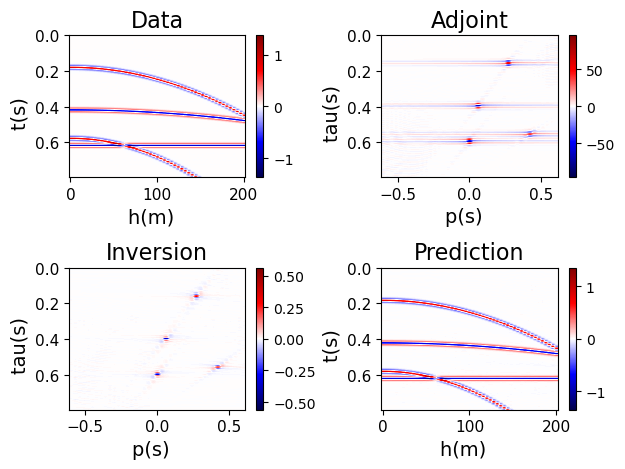

In [ ]:

# Inverse problem crime to create a group of parabolic moveout events
 dh = 4.
 h0 = 0.
 h = collect(0:1:50)*dh
 dp = 0.03 
 p = collect(-20:1:20)*dp
 p0 = p[1]

 Par_R = Dict(:h=>h,:p=>p,:dt=>0.004,:transf=>"parab")
 m = zeros(200,length(p))
    
     m[40,30]= 1.0
    m[100,23]=-1.0
    m[150,21]=-1.0
    m[140,35]=1.0

wave = Ricker(dt=0.004,f0=40)
Par_W = Dict(:wavelet=>wave)
    
# compute the data  d = W R m = L m

  d  = SeisConv(SeisRadon_tx(m,false;Par_R...),false;Par_W...)

# compute the adjoint ma = R'W' d

  ma = SeisRadon_tx(SeisConv(d,true;Par_W...),true; Par_R...);

# Damped least-squares solution via CG

  mcg,cost =  ConjugateGradients(d, [SeisConv, SeisRadon_tx],[Par_W,Par_R]; Niter=20, mu=00.1, tol=1.0e-5)

# Prediction of the data from Radon panel

  dpred = SeisConv(SeisRadon_tx(mcg,false;Par_R...),false;Par_W...);


subplot(221); SeisPlotTX(d,    dy=0.004, ox=h0, dx=dh, cmap="seismic",fignum=1,pclip=100, xlabel="h(m)", ylabel="t(s)", title="Data");colorbar()

subplot(222); SeisPlotTX(ma,   dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)",title="Adjoint");colorbar()

subplot(223); SeisPlotTX(mcg,  dy=0.004, ox=p0, dx=dp, cmap="seismic",fignum=1,pclip=100, xlabel="p(s)", ylabel="tau(s)", title="Inversion");colorbar()

subplot(224); SeisPlotTX(dpred,dy=0.004, ox=h0, dx=dh, cmap="seismic",fignum=1,pclip=100, xlabel="h(m)", ylabel="t(s)", title="Prediction");colorbar()

tight_layout()
savefig("./figs/parab_radon.png")


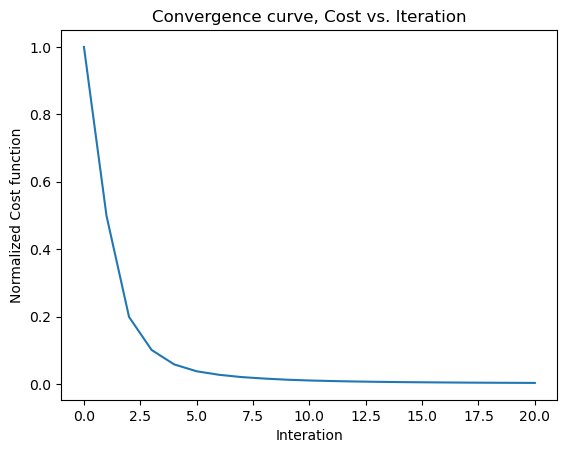

In [9]:
plot(cost); title("Convergence curve, Cost vs. Iteration"); xlabel("Interation"); ylabel("Normalized Cost function")
savefig("./figs/cg_radon_convergence.png")